In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact
import numpy as np

# 1.  input signal

In [ ]:
pass

# 2. LIF neuron

In [ ]:
class LIFNeuron(object):
    """Our LIF neuron class that can initiate a single neuron, 
    run the simulation for a certain number of steps while keeping track of the membrane voltage
    and plot the results of the run
    """
    def __init__(self, 
                 tau_m = 10, v_reset = -70, v_th = -50, I_e = 10e-8, dt = 0.1,
                g_ampa = 0.85, g_gaba = 0.85):
        '''This function is executed when we create an object from that class'''
        super(LIFNeuron, self).__init__()
        
        ### assign the attributes of the class
        self.tau_m = tau_m  # membrane time constant
        self.el = -75 # leak reversal potential
        
        self.r_m = 100e6 # membrane resistance
        self.v_reset = v_reset # reset voltage after a spike
        self.v_th = v_th # threshold voltage
        self.I_e = I_e # Input current
        
        
        self.v = -60 # starting voltage value for the simulation
        self.dt = dt # simulation timestep    
        
        
        ### Initiate the recording lists
        self.v_list = [self.v]
        self.t_list = [0]
        
        
        ### Initiate synaptic paramters
        self.ps_ampa = 0 # when starting the simulations the channels should be closed
        self.ampa_input = False # and there is no input
        self.g_ampa = g_ampa # strength of synaptic input
        
        self.e_ampa = 0 # reversal potential of the AMPA channel
        self.tau_ampa = 5.26 # in ms, AMPA is rather fast
        
        self.ps_gaba = 0 # when starting the simulations the channels should be closed
        self.gaba_input = False # and there is no input
        self.g_gaba = g_gaba # strength of synaptic input
        
        self.e_gaba = -80 # reversal potential of the GABA channel
        self.tau_gaba = 8 # in ms
        
        
        self.i_ampa_list = [0]
        self.g_ampa_list = [0]
    
    def timestep(self):
        '''
            This function performs an update step of the membrane voltage evolution
            we use forward euler
        '''
        ### Time evolution of the synaptic input
        if self.ampa_input == True:
            self.ps_ampa = 1 # if there is a spike in this time step, the channels open
            self.ampa_input = False # remove the input 
        else:
            dps_ampa_dt = -self.ps_ampa / (self.tau_ampa) # The channels close with an exponential decay
            self.ps_ampa += dps_ampa_dt * self.dt
            
        if self.gaba_input == True:
            self.ps_gaba = 1 # if there is a spike in this time step, the channels open
            self.gaba_input = False # remove the input 
        else:
            dps_gaba_dt = -self.ps_gaba / (self.tau_gaba) # The channels close with an exponential decay
            self.ps_gaba += dps_gaba_dt * self.dt
            
        ### Time evolution of the membrane potential
        i_ampa = self.g_ampa*self.ps_ampa*(self.e_ampa-self.v)
        i_gaba = self.g_gaba*self.ps_gaba*(self.e_gaba-self.v)
        if self.v <= self.v_th:
            dv_dt = (-self.v + self.el + self.r_m * self.I_e + i_ampa + i_gaba)/self.tau_m
            self.v += dv_dt * self.dt
        else:
            self.v = self.v_reset
            
    
        self.i_ampa_list.append(i_ampa)
        self.g_ampa_list.append(self.g_ampa * self.ps_ampa)
    
    
    def run_simulation(self, 
                       time_steps = 100,
                       ampa_inputs = [],
                       gaba_inputs = []):
        '''
            Function to run the simulation for a fixed number of time steps (time_steps)
            We can define synaptic events as time_steps in a list.
            either exitatory (ampa_inputs) or inhibitory (gaba_inputs)
        '''
        
        for ii in range(time_steps):
            
            # we can check whether our current timestep is in the list of inputs we provide
            if ii in ampa_inputs:
                self.ampa_input = True
            
            if ii in gaba_inputs:
                self.gaba_input = True
            
            self.timestep()
            
            self.v_list.append(self.v)
            current_time = self.t_list[-1] + self.dt
            self.t_list.append(current_time) 
            
    def plot_traces(self):
        '''
            Function to plot the simulated results
            creates a figure and plots the voltage traces vs. the simulated time
        '''
        
        plt.figure()
        plt.title('Time evolution of membrane voltage')

        plt.plot(self.t_list,self.v_list,linewidth=2.5)

        plt.xlabel('Time in ms')
        plt.ylabel('Voltage in mV')

        plt.ylim([-80,20])
    
    def plot_voltage_current_and_conductance(self):
        '''
            Function to plot the simulated results
            creates a figure with 3 subplots and plots 
            voltage traces, current traces and conductance traces vs. the simulated time
        '''
        fig, axes = plt.subplots(3)
        fig.suptitle('Comparison of excitatory postsynaptic voltage, current, and conductance')
        axes[0].plot(self.t_list,self.v_list,linewidth=2.5)
        axes[1].plot(self.t_list,self.i_ampa_list,linewidth=2.5)
        axes[2].plot(self.t_list,self.g_ampa_list,linewidth=2.5)

        axes[0].set(
            xlabel = 'Time in ms',
            ylabel = 'Voltage in mV'
            )
        axes[1].set(
            xlabel = 'Time in ms',
            ylabel = 'Current in micro A'
            )
        axes[2].set(
            xlabel = 'Time in ms',
            ylabel = 'Conductance in nS'
            )
        plt.tight_layout() # This makes the plot cleaner, you can try how it looks if you remove this part
        
        
def run_and_plot(I_e, gaba_input_timestep):
    neuron = LIFNeuron(I_e = I_e*1e-8, g_ampa = 0.85, g_gaba = 0.8)
    neuron.run_simulation(2000, 
                        ampa_inputs = [1000, 1050, 1100],
                       gaba_inputs = [gaba_input_timestep],
                       )
    neuron.plot_traces()
    
    
    # reading out the time and voltage value so that the arrow points to the plot
    # If you don't know how to access an element in the list, feel free to ask
    x_input = neuron.t_list[gaba_input_timestep] 
    y_input = neuron.v_list[gaba_input_timestep]
    
    # use the annotate function to plot an arrow and the text 'GABA input'
    plt.annotate('GABA input', xy =(x_input, y_input),
                xytext =(x_input-40, y_input + 20), 
                arrowprops = dict(arrowstyle='->',facecolor ='#CC1414', edgecolor='#CC1414',
                                  shrinkA = 0.1))

interact(run_and_plot,I_e = 5, gaba_input_timestep=(700,1150,10))

# 3. Simulation

In [17]:
############
###import###
############
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython.display import clear_output
from matplotlib.gridspec import GridSpec
#######################
###parameter setting###
#######################

## simulation parameters

# scalars
duration=1500 #Duration of a single run in ms.
dt=0.1 # Simulation time step in ms.
NRuns=100 #Number of consecutive runs in one simulation.
stopnow=0 # This is a flag to stop the while loop in case the EPSP routine below is uncommented

noisetau=50 # Filter time for the input in ms
Backgroundrate=5*dt/1000 # Background spiking probability 5Hz*dt (= 0.0005) (see Technical Appendix 6.2.1).
ApproximateNormalizingFactor=0.03 # This serves to normalize the trace to an approximate peak value of 1
Maxrate=500*dt/1000 # Peak spiking probability 500Hz*dt (= 0.05))
NSigs=8 # Number of input signals.
NCells=1000 # Number of input spike trains.
ExFrac=0.8 #Fraction of Excitatory spike trains.
ExGroupsize=(NCells*ExFrac)/NSigs # Number of spike trains in each excitatory input group. =100
InGroupsize = math.ceil((NCells*(1-ExFrac))/NSigs) # Number of spike trains in each inhibitory input group. =25

# vectors
Input=np.zeros(NSigs) # A vector that holds the momentary input signal for each signal channel
Timevector=np.arange(0.1,duration+0.1,dt) # A vector of time in ms, in steps of dt.
Exkeep=Timevector*0
Inkeep=Timevector*0 # Vectors to keep the synaptic currents.
FilteredWhiteNoise=np.zeros(8) # A vector to create the time-filtered input
InputGroup=np.zeros(NCells) # A Vector that keeps track of which spike train belongs to which input
InputSpikeRefr=np.zeros(NCells) # To keep track of the input spike train refractory periods)
tolos=0 # (== t(ime)o(f)l(ast)(o)utput (s)pike (Keeping track of the output cell's refractory period )
Synapse=np.ones(NCells) #Synaptic weights
sgEx=np.zeros(NCells)
sgIn=np.zeros(NCells) # Vectors to save the group-wise synaptic conductances the cell experiences.
AveExCurr=np.zeros(NSigs)
AveInCurr=np.zeros(NSigs) # Vectors to save the group-wise synaptic currents the cell experiences.
pre=np.zeros(NCells) # A Vector to save the presynaptic learning trace.
Time=np.arange(NRuns)
Rate=np.zeros(NRuns) #Vectors for plotting


## inhibitory plasticity related parameters
eta=0.001 #Learning Rate
alpha=0.25*eta #Depression Factor * Learning Rate
tauPlasticity=20 #Time window of the learning rule.
gBarEx=0.014 # Scaling factor of the excitatory synaptic conductance in units of the leak (gleak = 10 nS)
gBarIn=0.035 # Scaling factor of the inhibitory synaptic conductance in units of the leak (gleak = 10 nS)
tauEx=5 # Excitatory synaptic time constant, in ms.
tauIn=10 # Inhibitory synaptic time constant, in ms.

## neuron related parameters
tRef=5 # Refractory period for the spike trains.
VRest=-60 #Resting potential in mV.
Vth=-50 # Threshold, in mV.
taumem=20 # Membrane time constant, in ms.
EAMPA=0 # Excitatory reversal potential, in mV.
EGABA=-80 # Inhibitory reversal potential, in mV.


## Pre-calculated exponential factors for speed of simulation
expGEx=np.exp(-dt/tauEx)
expGIn=np.exp(-dt/tauIn)
expPlasticity=np.exp(-dt/tauPlasticity)
expnoise=np.exp(-dt/noisetau)

### assign group number to 1000 cells

In [18]:
## InputGroups
# pre synaptic excitatory neuron 1-100 : 1
#                     101-200 : 2
#                     701-800 : 8
# pre synaptic inhibitory neuron: 801-825 : -8
#                                 826-850 : -7
#                                 ...
#                                 976-1000 : -1

# ii will be used as index
# i needs to be from 1 to 1000
# mitigation strategy = i = ii + 1
# for NCell[1:800] : InputGroup[]
temptype=0
for ii in range(NCells):
    i = ii + 1
    if i<=NCells*ExFrac:
        if (i-1) % ExGroupsize == 0:
            temptype=temptype+1
        
        InputGroup[ii]= temptype
    else:
        if i % InGroupsize==0:
            temptype=temptype-1
        
        InputGroup[ii]= -temptype

InputGroup[999]=InputGroup[998]
# This routine assigns every spike train to an input group, starting with group 1 and ending
#with group NSIgs for the excitatory spike trains and then going back from NSigs to 1 for the
#inhibitory spiketrains. To label inhibitory spike trains uniquely, their group identity is assigned
#as a negative number.


## Synapse Tuning
for i in range(800):
    Synapse[i] = 0.3 + (1.1/(1+(InputGroup[i]-5)**4))+np.random.rand()*0.1

for i in range(801,NCells):
    Synapse[i] = 0.1

# This routine assigns a synaptic weight to every synapse. Excitatory synapses are tuned
#according to their group identity (plus a noise term) to resemble the tuning reported in (7).
#Inhibitory synapses are uniformly weak.

In [19]:
## plot functions

def synaptic_currents(axis,Timevector,Exkeep,Inkeep,duration):

    # to pA
    axis.plot(Timevector, Exkeep/100,'k', linewidth= 1)
    # plotting in units of nA hence the values need to be divided by 100, see above.
        
    axis.plot(Timevector,Inkeep/100,c= [0.6 ,0.6, 0.6], linewidth= 1)
    axis.plot(Timevector,(Inkeep+Exkeep)/100,c= [0, 0.6, 0])
    axis.set_ylabel('Synaptic Currents [nA]')
    # set axis limits
    axis.set_xlim([0, duration])
    axis.set_ylim([-3, 3])
    
    return axis

def mem_pot(axis,stopnow,Timevector,V,duration):
    if (stopnow==0):
        axis.plot(Timevector, V, 'k')
        axis.set_ylabel('Mem. Pot. [mV]')
        axis.set_xlabel('Time [ms]')
        # set axis limits
        axis.set_xlim([0, duration])
        axis.set_ylim([-65, 5])
        
    return axis 

def mean_synaptic_strength_and_synaptic_strength(axis,Time,Rate,runcount,NRuns,duration,synaptic_strength_x,synaptic_strength_y1,synaptic_strength_y2,synaptic_strength_y3):
    # there are two y-axis on this graph
    # drawing the y-axis on the left second
    axis.plot(Time[0:runcount], Rate[0:runcount], '.-k')

    axis.set_ylabel('Mean Output Rate [Hz]')
    axis.set_ylim([0, 100])

    axis.set_xlabel('Time [s]')
    axis.set_xlim([0, NRuns*duration/1000])

    axis2 = axis.twinx()
    
    # added arrays outside of the loop
    # in matlab the points were added to the plot
    # in python the plot is overwritten - we soo only the latest data
    # mitigation strategy = use lists to collect points over time
    synaptic_strength_x.append(runcount*duration/1000)
    synaptic_strength_y1.append(np.mean(Synapse[924:949])*gBarIn*10000)
    synaptic_strength_y2.append(np.mean(Synapse[899:924])*gBarIn*10000)
    synaptic_strength_y3.append(np.mean(Synapse[874:899])*gBarIn*10000)

    # drawing the y-axis on the right first
    axis2.plot(synaptic_strength_x, synaptic_strength_y1, '.', c='r')
    # (Plotted in units of pS)
    axis2.plot(synaptic_strength_x, synaptic_strength_y2, '.', c=[0.5, 0.0, 0.5])
    # (Plotted in units of pS)
    axis2.plot(synaptic_strength_x, synaptic_strength_y3,  '.', c='b')
    # (Plotted in units of pS)
    axis2.set_ylabel('Mean Synaptic Strength [pS]')
    # set axis limits
    axis2.set_ylim([0, 800])

    return axis

def mean_synaptic_currents(axis,AveExCurr,AveInCurr,AveCurrCounter):
    x = list(range(1,9))
    y1 = 10*(-AveExCurr/AveCurrCounter)
    y2 = 10*(AveInCurr/AveCurrCounter)

    axis.plot(x, y1,'-ks',linewidth=2,\
        markeredgecolor='k',\
        markerfacecolor='k',\
        markersize=10)

    axis.plot(x, y2,'-ks',linewidth=2,\
        markeredgecolor='k',\
        markerfacecolor='w',\
        markersize=10)
    
    # set axis limits
    axis.set_xlabel('Signal Number')
    axis.set_ylabel('Mean Synaptic Currents [pA]')

    axis.set_xlim([1, 8])
    axis.set_ylim([0, 270])

    return axis

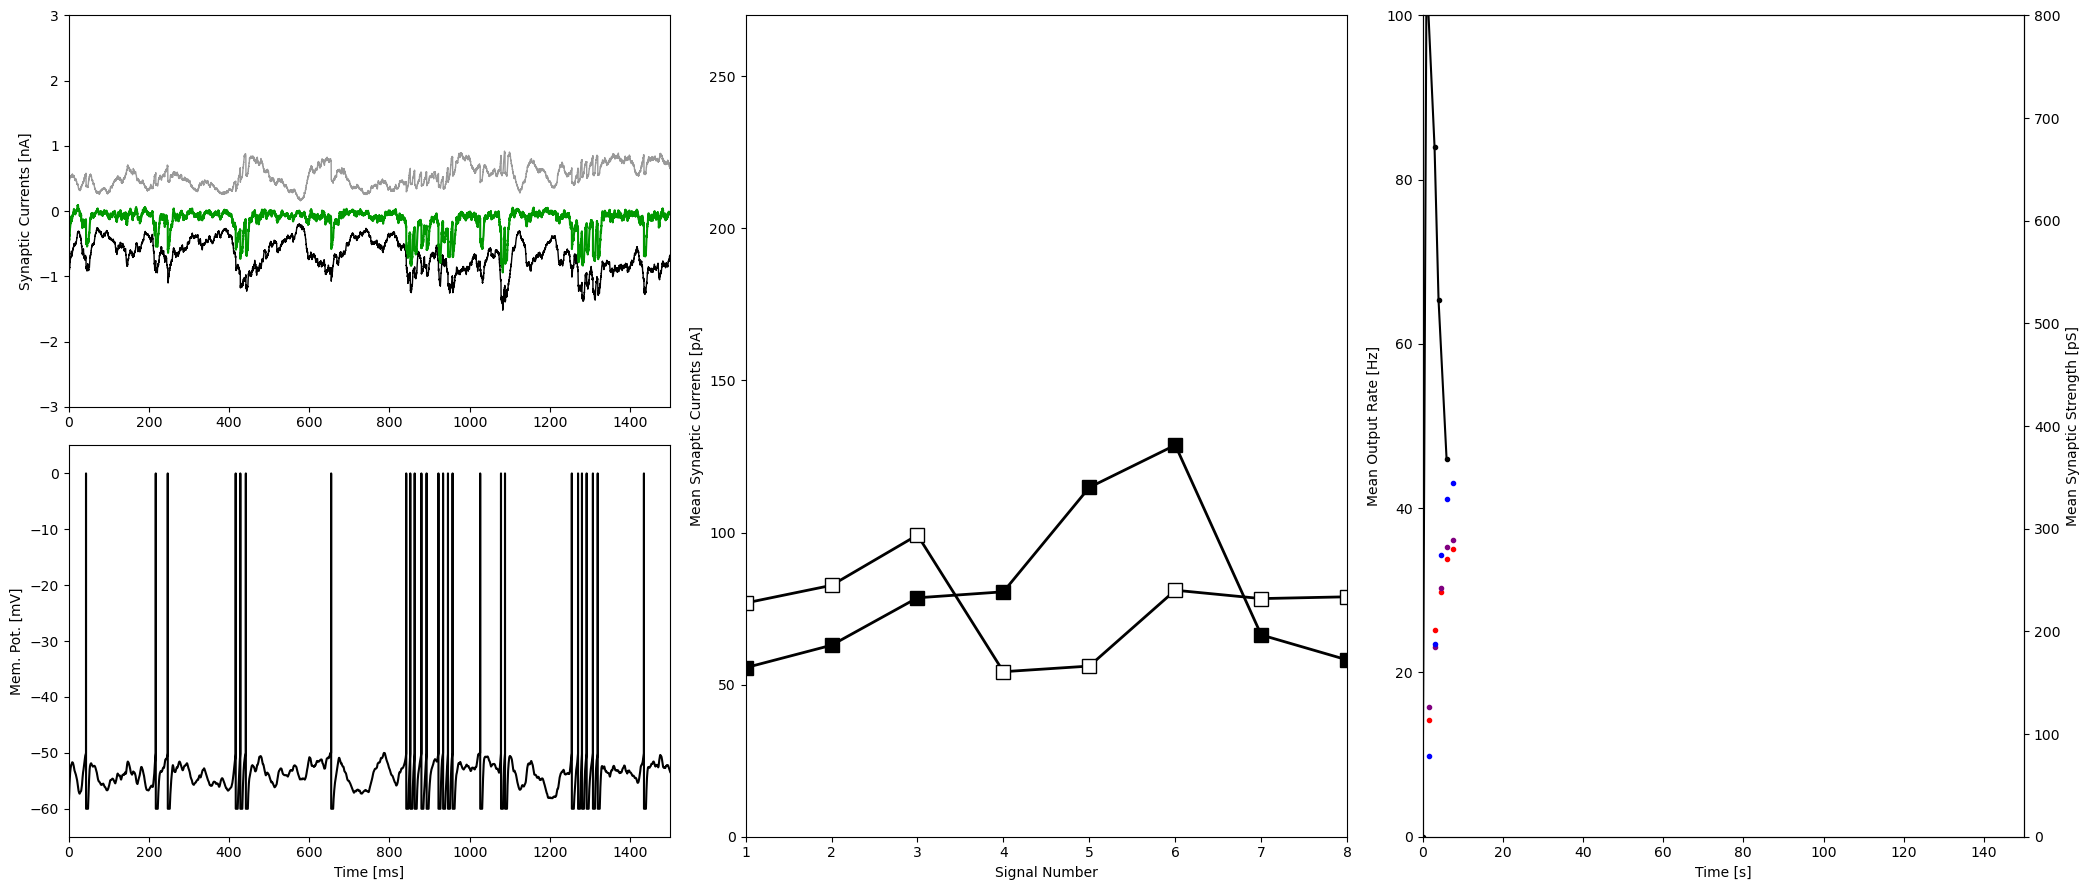

KeyboardInterrupt: 

In [20]:
##################
## Simulation#####
##################

## Initialize values
gEx=0 # Overall excitatory synaptic conductance.
gIn=0 # Overall inhibitory synaptic cconductance.
gLeak=1 # Leak conductance (Everything else is normalized in respect to the leak.)
V = np.zeros(len(Timevector)) # we will need this when calculating the V at moment t
# this will allow us to set V[t]
V[0]=VRest # Membrane potential is initially at VRest.

post=0 # Postsynaptic learning trace.

InputSpikeCount=0
OutputSpikeCount=0
AveCurrCounter=0 #Counters for rates and averaging.
tRunning=0
runcount=0
going=1 # Time parameters are initialized

fig = plt.figure(figsize=(21,9), constrained_layout=True)
synaptic_strength_x = []
synaptic_strength_y1 = []
synaptic_strength_y2 = []
synaptic_strength_y3 = []

## for run in 1-100: 100
##    for time in 0-1500ms (15000 0.1dt ) 15000
##       for presynaptic cells in 1-800  800
## 100 * 15000 * 800


## Start of the loops
while going>0:

    #if runcount == 10:
    #    going -= 1

    runcount=runcount+1
    # A counter to keep track of consecutive runs.
    OutputSpikeCount=0
    for i in range(NSigs):
        AveExCurr[i]=0
        AveInCurr[i]=0
    
    AveCurrCounter=0
    # 100 * 1500 ms = 150s
    # 0 - 1500 ms
    for t in np.arange(1,len(Timevector)):
        # The time loop begins here.
        tRunning=tRunning+dt

        gEx = gEx*expGEx
        gIn = gIn*expGIn
        for i in range(NSigs):
            sgEx[i] = sgEx[i]*expGEx
            sgIn[i] = sgIn[i]*expGIn
        
        # The synaptic conductances decay exponentially towards 0.
        for i in range(800,NCells):
            pre[i]= pre[i]*expPlasticity
        
        post=post*expPlasticity
        # The learning traces decay exponentially towards 0.

        ## Input Signals
        ## Input = [ 0.25 0.3 ..   0.15]
        for i in range(NSigs):
            re=np.random.rand()-0.5
            FilteredWhiteNoise[i] = re -(re - FilteredWhiteNoise[i])*expnoise
            Input[i]=Backgroundrate + max(0, Maxrate*FilteredWhiteNoise[i])/ApproximateNormalizingFactor

        ## Presynaptic spike trains
        for i in range(NCells):

            # InputGroup values from -8 to 8
            # as a result, then the index of 8 is used, it has to be translated to 7
            # as the python the index starts with 0
            # and in mathlab - with 1
            InputGroupIndex = int(abs(InputGroup[i])) - 1

            if  np.random.rand() < Input[InputGroupIndex] and InputSpikeRefr[i]<=0:
                # If a Spiketrain fired a spike, (see also 6.2.1) ...
                if InputGroup[i]>0:
                    # .. and if it is excitatory...
                    gEx = gEx + (gBarEx * Synapse[i])
                    # ... increase the excitatory synaptic conductance variable according to
                    # the strength of the synapse
                    sgEx[InputGroupIndex]=sgEx[InputGroupIndex] + gBarEx*Synapse[i]
                    # (Keeping track of the synaptic conductances group-wise for plotting.)
                else:
                    # otherwise (meaning the synapse is inhibitory)...
                    gIn = gIn + gBarIn * Synapse[i]
                    # ... increase the synaptic conductance by the synapse strength
                    sgIn[InputGroupIndex]=sgIn[InputGroupIndex] + gBarIn*Synapse[i]
                    # (To keep track of the synaptic conductances group-wise for plotting.)
                    pre[i]= pre[i] + eta
                    # Update the presynaptic learning trace.
                    Synapse[i] =Synapse[i] + post - alpha
                    # Update the synaptic strength according to the rule.
                    # → add the effect of proximate post synaptic spikes, and subtract α.
                    if(Synapse[i] <=0):
                        Synapse[i]=0
                    
                    # Ensure non-negative synaptic weights.
                
                InputSpikeRefr[i]=tRef
                # ... Also: set the refractory time counter to the value of refractoriness
                InputSpikeCount=InputSpikeCount+1
                # .. and count the overall number of input spikes
            else:
                # meaning if no presynaptic spike was evoked:
                InputSpikeRefr[i]=InputSpikeRefr[i]-dt
                # subtract dt from the refractory counter.
            
        

        ## Membrane potential and postsynaptic spikes.
        if ((tRunning - tolos) < tRef):
            V[t] = VRest
            # If the Cell is refractory, keep V at Vrest
        else:
            # Meaning: if the cell is not refractory, ...
            gTot = gLeak + gEx + gIn
            # calculate the total membrane conductance,
            tauEff=taumem/gTot
            # and the effective time constant, as well as...
            VInf = ((gLeak*VRest + gEx * EAMPA+ gIn*EGABA)/gTot)
            # the membrane potential that V strives towards.
            V[t] = VInf + (V[t-1] - VInf)*np.exp(-dt/tauEff)
            # Use the above to update the membrane potential
            for i in range(NSigs):
                AveExCurr[i]= AveExCurr[i] + sgEx[i]*(V[t]-EAMPA)
                AveInCurr[i]= AveInCurr[i] + sgIn[i]*(V[t]-EGABA) + (gLeak*(V[t]-VRest))/NSigs
            
            AveCurrCounter=AveCurrCounter+1
            # The above routine keeps track for the group-wise input currents for plotting but
            # does not affect the behavior of the cell. We divide the (mostly inhibitory acting)
            # leak current evenly to all Groups,since each input signal causes the same absolute
            # amount of leak current (by deflecting the membrane potential away from rest with
            # identical statistics over time for each signal).
        
        if (V[t]>Vth):
            # If the membrane potential hits threshold...
            tolos=tRunning
            # ... set the refractory counter to the current time step
            V[t-1]=0
            # ... set the last membrane potential before the spike to zero (for plotting)
            V[t]=VRest
            # ... reset the current membrane potential to Vrest.
            OutputSpikeCount=OutputSpikeCount+1
            # ... count the spike.
            post = post + eta
            # ... update the postsynaptic learning trace
            for i in range(800,NCells):
                Synapse[i] = Synapse[i]+pre[i]
            
            # update all synapses according to the rule
            # → Add the effect of proximate presynaptic spikes.
        
        # subtract dt from the refractory counter.
        Exkeep[t]=gEx*(V[t]-EAMPA)
        Inkeep[t]=gIn*(V[t]-EGABA)
        # For plotting purposes, keeps track of the excitatory and inhibitory synaptic currents.
        # Because everything is normalized by the leak conductance, the values are saved in
        # units of 10nS × mV (= 10−11 Amp = [10pA]).
        # To plot in units of nA, one has to divide this number by 100.
    
    # End of the time loop
    Rate[runcount]=OutputSpikeCount/duration*1000
    Time[runcount]=runcount*duration/1000


    ##################
    # Plotting #######
    ##################

    before = 1
    during = 5
    after = 10

    clear_output(wait=True)

    plt.rcParams['figure.figsize'] = (21, 9)
    ax1 = plt.subplot2grid((2, 3), (0,0), colspan = 1, rowspan = 1)
    ax2 = plt.subplot2grid((2, 3), (1,0), colspan = 1, rowspan = 1)
    ax3 = plt.subplot2grid((2, 3), (0,1), colspan = 1, rowspan = 2)
    ax4 = plt.subplot2grid((2, 3), (0,2), colspan = 1, rowspan = 2)
    ax1 = synaptic_currents(ax1,Timevector,Exkeep,Inkeep,duration)
    ax2 = mem_pot(ax2,stopnow,Timevector,V,duration)
    ax3 = mean_synaptic_currents(ax3,AveExCurr,AveInCurr,AveCurrCounter)
    ax4 = mean_synaptic_strength_and_synaptic_strength(ax4,Time,Rate,runcount,NRuns,duration,synaptic_strength_x,synaptic_strength_y1,synaptic_strength_y2,synaptic_strength_y3)
    plt.tight_layout()
    plt.show()


    if(runcount>=NRuns):
        going=0
    
    if (stopnow==1):
        going=0
    
    # (This is only ==1 when the EPSP routine is uncommented)

# End of the while loop

## what to do next

0. fix signal current plot

1. add the LIF neuron class

2. opitimize the loops part

    
    for run in 1-100: 100   
        &nbsp;&nbsp;for time in 0-1500ms (15000 0.1dt ) 15000    
        &nbsp;&nbsp;&nbsp;&nbsp;   for presynaptic cells in 1-800  800    
    

3. signal producing 

4. animation
